Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotnine

Note: you may need to restart the kernel to use updated packages.


In [4]:
# import packages
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [5]:
# define url
url = "http://bit.ly/2IgDF0E"

# read data
df_voles = pd.read_csv(url)

Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [6]:
# display data
df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


## EDA


# display data
df_voles.head()Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

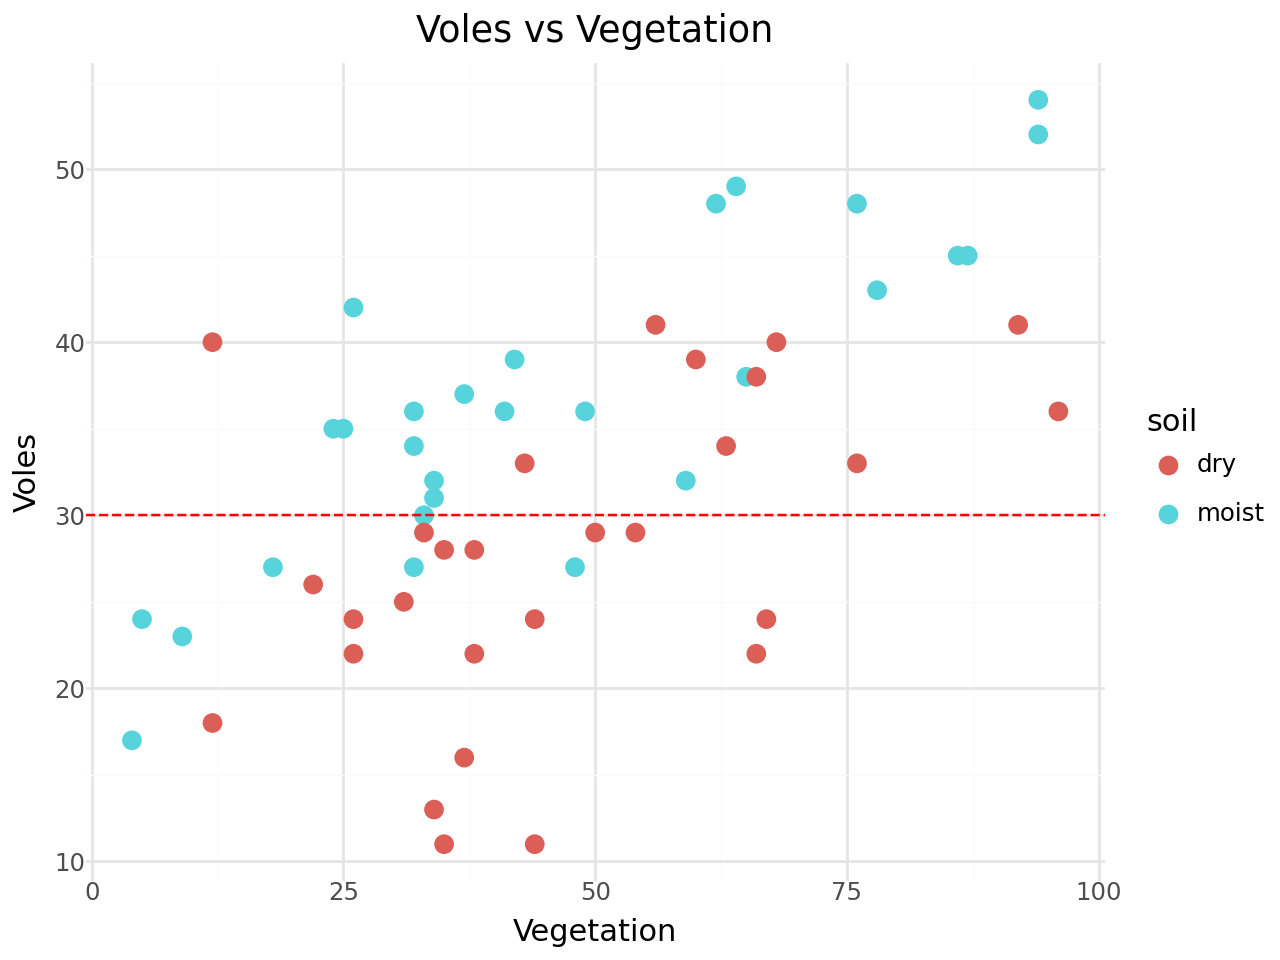

In [7]:
# import necessary packages
from plotnine import ggplot, geom_point, aes, labs, theme_minimal, geom_hline

# generate graph
plot = (ggplot(df_voles, aes(x = 'veg', y = 'voles', color = 'soil')) +
            geom_point(size=3) +
            labs(
                title='Voles vs Vegetation',
                x='Vegetation',
                y='Voles') +
            geom_hline(yintercept = 30, linetype='dashed', color='red') +
            theme_minimal())
plot

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [8]:
# create the column transformer
col_transformer = make_column_transformer(
        (OneHotEncoder(drop='first'), ['soil']),
        remainder='passthrough') # ensures that 'veg' is passed through

# create a pipeline with col_transformer and LinearRegression
pipeline = make_pipeline(col_transformer, LinearRegression())

# prepare trraining data
X = df_voles[['soil', 'veg']]
y = df_voles['voles']

# train model
pipeline.fit(X, y)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [9]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [10]:
# utilize funtion to generate regression table
regression_table = get_regression_table(pipeline)

# display results
regression_table

,term,estimate
0,onehotencoder__soil_moist,9.100298
1,remainder__veg,0.259069
2,intercept,15.464026


❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

From the regression table we can see that vegitation has a coefficent of 0.26, meaning that for every percentage increse in the cover of vegitation, the vole population increases by '0.26'. The model also shows that moist soil has a large positive impact on the vole population, increating it by '9.10'. 

So from these facts we can determine that protecting site with high vegitation cover would be a more effective way to perserve the vole population. However, involving sites with moist soil would be even more effective, as the soil hydration has a much larger impact on the volve population than vegitation alone.

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:** We can see from the calculation below that a vegitation cover of ~56% is needed to maitian a vole population of at least 30 in a dry site.

In [11]:
# define variables
intercept_dry = pipeline.named_steps['linearregression'].intercept_
veg_coef = pipeline.named_steps['linearregression'].coef_[-1]

target_voles = 30

# calculate required vegitation
required_veg_cover = (target_voles - intercept_dry) / veg_coef

#required_veg_cover
print(f' Needed Vegitation Cover: {round(required_veg_cover,2)}%')

 Needed Vegitation Cover: 56.11%


❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer:** We can see from the calculation below that a site with moist soil and 40% vegitation cover has a predicted vole population of ~35, using the model generated from the avalible data. 

In [12]:
# new data to make prediction on
new_data = pd.DataFrame({"soil": ["moist"], "veg": [40]})

# make prediction
predicted_voles = pipeline.predict(new_data)

# predicted voles
print(f' Predicted Voles: {round(predicted_voles[0],2)}')

 Predicted Voles: 34.93
